<a href="https://colab.research.google.com/github/101Vaibhav04/Portfolio-Optimization/blob/main/expCov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

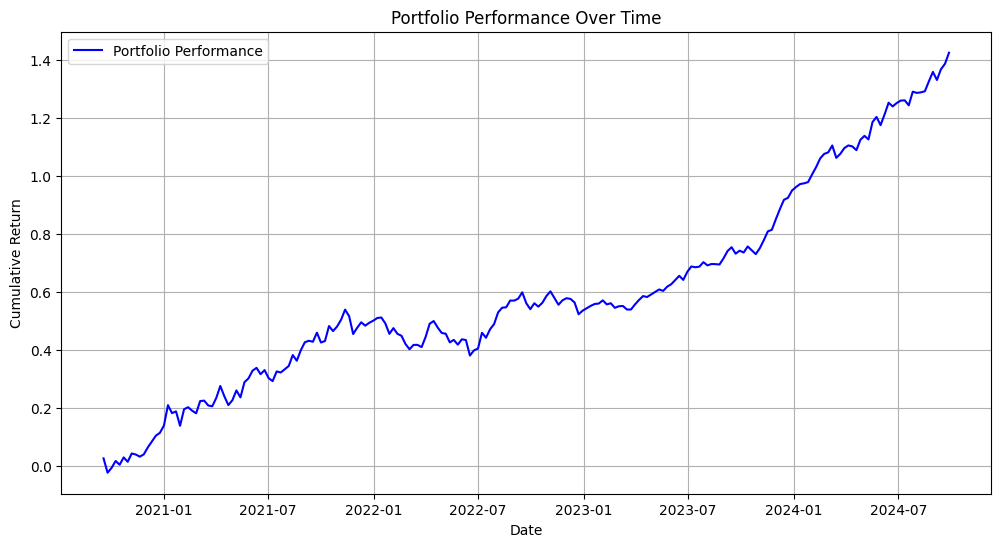

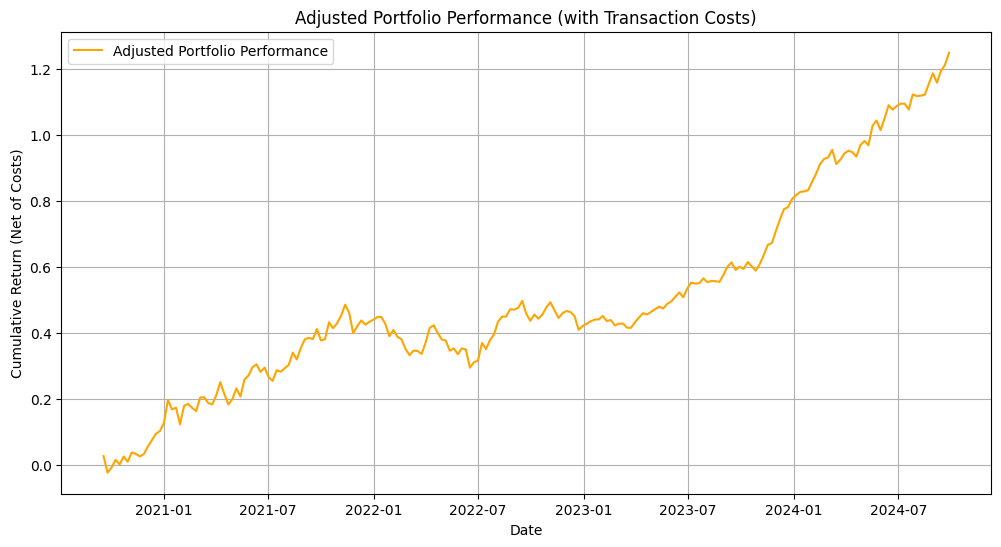

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/JSWSTEEL_ohlc (1).xlsx'  # Replace with your actual file path
data = pd.read_excel(file_path)

# Convert the 'Date' column to datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

# Resample the data by weeks, ending on Friday ('W-FRI')
weekly_data = data.resample('W-FRI').last()

# Calculate percentage weekly returns
weekly_returns = weekly_data.pct_change().dropna()

# Set the span for the exponential weighting
span = 100 # Adjust span based on how much you want to weigh past data

# Set window size for rolling window (e.g., 50 weeks)
window_size = 50

# Function to calculate portfolio variance given weights and covariance matrix
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Constraints and bounds for the optimization
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Sum of weights must equal 1
bounds = None  # We'll set bounds later based on the number of assets

# Initialize variables to store portfolio weights and performance data
portfolios = []
dates = weekly_returns.index[window_size:]  # Dates after the first window
portfolio_performance = []

# Optimize portfolio for each rebalancing period
for i in range(len(dates)):
    # Select the rolling window of weekly returns
    rolling_window_returns = weekly_returns.iloc[i:i + window_size]

    # Compute the average weekly returns for each stock over the rolling window
    average_returns = rolling_window_returns.mean()

    # Select the top 20 stocks with the highest average returns
    selected_stocks = average_returns.nlargest(20).index

    # Filter the rolling window returns for the selected stocks
    rolling_window_selected_returns = rolling_window_returns[selected_stocks]

    # Compute exponentially weighted covariance matrix for the window
    rolling_cov_matrix = rolling_window_selected_returns.ewm(span=span).cov(pairwise=True)

    # Extract the covariance matrix for the most recent period in the window
    cov_matrix_for_period = rolling_cov_matrix.iloc[-len(selected_stocks):, :len(selected_stocks)]

    # Adjust bounds based on the number of selected assets (20 in this case)
    bounds = tuple((0, 1) for _ in range(len(selected_stocks)))

    # Initial equally weighted portfolio guess
    initial_weights = np.array([1.0 / len(selected_stocks)] * len(selected_stocks))

    # Optimize portfolio weights to minimize variance
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix_for_period.values,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    # Store the optimal weights for this period
    portfolios.append(result.x)

    # Calculate the portfolio return for the next week (after the current rolling window)
    portfolio_return = np.dot(result.x, weekly_returns[selected_stocks].iloc[i + window_size])
    portfolio_performance.append(portfolio_return)

# Convert to a cumulative performance curve
portfolio_performance = pd.Series(portfolio_performance).cumsum()

# Ensure the index is in datetime format for plotting
dates = weekly_returns.index[window_size:]  # Adjust the dates for the rolling window

# Plot the portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(dates[:len(portfolio_performance)], portfolio_performance, label='Portfolio Performance', color='blue')
plt.title('Portfolio Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# Define the transaction cost rate
transaction_cost_rate = 0.001

# Calculate the transaction costs by comparing weights week to week
transaction_costs = []
for i in range(1, len(portfolios)):
    # The change in weights from previous to current week
    weight_change = np.abs(portfolios[i] - portfolios[i - 1])

    # Calculate transaction cost
    cost = transaction_cost_rate * np.sum(weight_change)
    transaction_costs.append(cost)

# Pad the beginning of transaction_costs with zero to match lengths
transaction_costs = [0] + transaction_costs  # Add a zero for the initial week

# Adjust the portfolio performance by deducting cumulative transaction costs
adjusted_portfolio_performance = portfolio_performance - np.cumsum(transaction_costs)

# Plot the adjusted portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(dates[:len(adjusted_portfolio_performance)], adjusted_portfolio_performance, label='Adjusted Portfolio Performance', color='orange')
plt.title('Adjusted Portfolio Performance (with Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Net of Costs)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Backtesting metrics calculation
# Convert weekly returns to a DataFrame for easier analysis
portfolio_returns_df = pd.DataFrame({'Portfolio Returns': pd.Series(portfolio_performance).pct_change().dropna()})
portfolio_returns_df.index = dates[1:len(portfolio_returns_df) + 1]

# Annualized returns
annualized_return = portfolio_returns_df['Portfolio Returns'].mean() * 52  # 52 weeks in a year

# Annualized volatility (standard deviation of returns)
annualized_volatility = portfolio_returns_df['Portfolio Returns'].std() * np.sqrt(52)

# Sharpe ratio (assuming risk-free rate = 0)
sharpe_ratio = annualized_return / annualized_volatility

# Maximum Drawdown
cumulative_returns = (1 + portfolio_returns_df['Portfolio Returns']).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (rolling_max - cumulative_returns) / rolling_max
max_drawdown = drawdown.max()

# Calmar ratio (annualized return divided by maximum drawdown)
calmar_ratio = annualized_return / max_drawdown

# Sortino ratio (downside deviation based)
downside_returns = portfolio_returns_df['Portfolio Returns'][portfolio_returns_df['Portfolio Returns'] < 0]
downside_std = downside_returns.std() * np.sqrt(52)
sortino_ratio = annualized_return / downside_std

# Display the performance metrics
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")


Annualized Return: 53.34%
Annualized Volatility: 357.41%
Sharpe Ratio: 0.15
Max Drawdown: 69.80%
Calmar Ratio: 0.76
Sortino Ratio: 0.13


<ipython-input-18-40e1e8b2fe1e>:109: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Running backtest...

Backtest Results:
Total Return (including initial capital): 4.5052
This means for every $1 invested, you now have $4.51
Profit-only Return: 350.5205%
Annualized Return: 44.91%
Annualized Volatility: 17.91%
Sharpe Ratio: 2.17
Sortino Ratio: 2.24
Max Drawdown: -12.59%
Calmar Ratio: 3.57


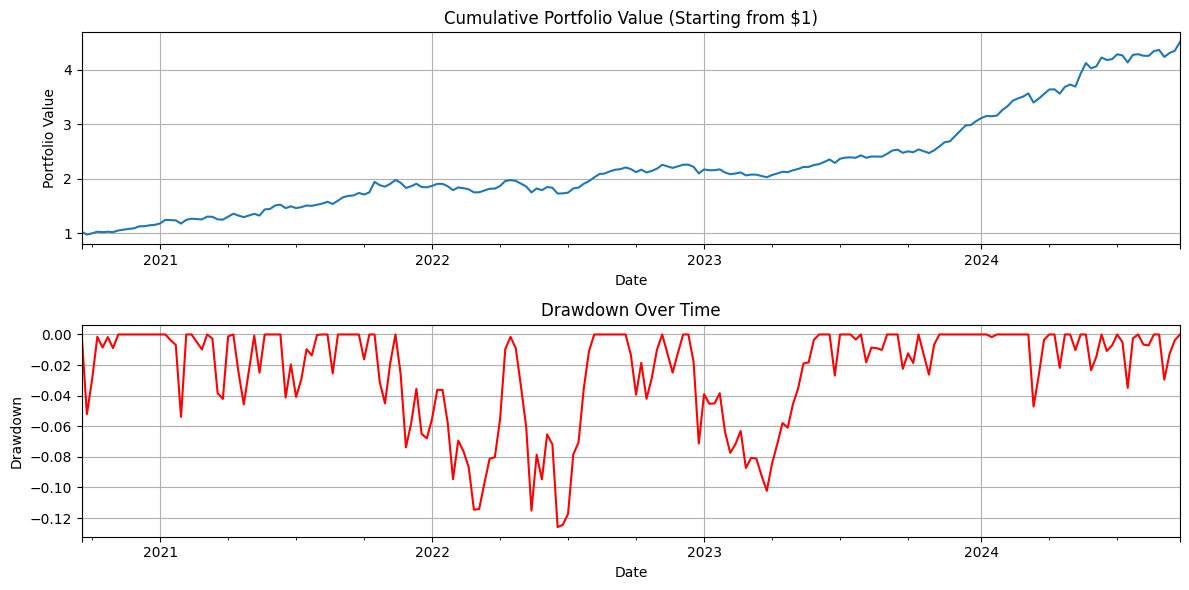


Stock weightage for week of 2024-08-29:
TRENT: 0.0500
HAL: 0.0500
BEL: 0.0500
BAJAJAUTO: 0.0500
ADANIGREEN: 0.0500
VEDL: 0.0500
COALINDIA: 0.0500
INDIGO: 0.0500
ADANIENT.1: 0.0500
HINDZINC: 0.0500
ABB: 0.0500
ONGC: 0.0500
SIEMENS: 0.0500
powergrid: 0.0500
VBL: 0.0500
M&M: 0.0500
NTPC: 0.0500
TATAMOTORS: 0.0500
BHARTIARTL: 0.0500
DLF: 0.0500


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def exponential_weights(n, alpha=0.94):
    """Calculate exponentially weighted weights."""
    weights = np.array([(1 - alpha) ** i for i in range(n)])
    return weights / np.sum(weights)

def exponentially_weighted_cov_matrix(returns, alpha=0.94):
    """Calculate the exponentially weighted covariance matrix."""
    n = len(returns)
    weights = exponential_weights(n, alpha)
    mean_return = np.average(returns, axis=0, weights=weights)
    deviations = returns - mean_return
    weighted_cov = np.dot(deviations.T, weights[:, None] * deviations)
    return weighted_cov

def portfolio_variance(weights, cov_matrix):
    """Calculate portfolio variance given weights and covariance matrix."""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns, alpha=0.94):
    """Create a minimum variance portfolio using exponentially weighted covariance."""
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    cov_matrix = exponentially_weighted_cov_matrix(returns, alpha)
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def get_stock_weightage(weekly_returns, current_date):
    """Get stock weightage for the top stocks based on historical returns."""
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]
    weights = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights

def calculate_drawdown(cumulative_returns):
    """Calculate drawdown and maximum drawdown."""
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def sortino_ratio(returns, target=0, periods_per_year=52):
    """Calculate the Sortino ratio."""
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

def calmar_ratio(annualized_return, max_drawdown):
    """Calculate the Calmar ratio."""
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

def backtest_strategy(df):
    """Run the backtest strategy for portfolio returns."""
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage(weekly_returns.iloc[:i], current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    # Adjust to make sure the length of portfolio_returns and index match
    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]

    return pd.Series(portfolio_returns, index=valid_index), weightage_history

# Load the data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate cumulative returns and metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1
annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

# Calculate drawdown and additional metrics
drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
calmar = calmar_ratio(annualized_return, max_drawdown)
sortino = sortino_ratio(portfolio_returns)

# Print backtest results
print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")

# Plot cumulative returns and drawdown
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

# Get weightage for the last date in the dataset
last_date = df.index[-21]
try:
    weightage = get_stock_weightage(calculate_weekly_returns(df), last_date)
    print(f"\nStock weightage for week of {last_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")
